In [294]:
import warnings
warnings.filterwarnings("ignore")
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)



import optuna
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
import keras 
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.utils import resample
from keras.models import Sequential
from keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras import models
from keras.utils import plot_model

url = "https://raw.githubusercontent.com/kasra-sal/Password_Strength/main/data.csv"
data = pd.read_csv(url, on_bad_lines='skip')
data.head()

,password,strength
0,kzde5577,1
1,kino3434,1
2,visi7k1yr,1
3,megzy123,1
4,lamborghin1,1


<AxesSubplot: xlabel='strength', ylabel='count'>

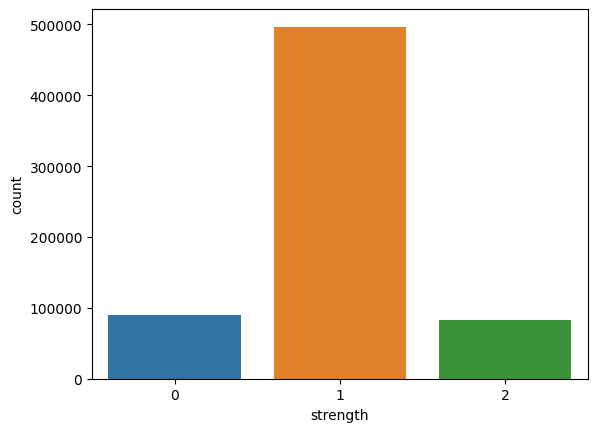

In [95]:
sns.countplot(x=data['strength'])

In [225]:
# Assigning variables to each label in order to use it for downsampling
weak = data[data['strength']==0]
medium = data[data['strength']==1]
strong = data[data['strength']==2]

# data downsampling function
def data_downsampling(x):
  return resample(x,replace=True,n_samples=len(weak),random_state=42) 

medium_resample = data_downsampling(medium)
strong_resample = data_downsampling(strong)

# combining the labels 
data = pd.concat([weak,medium_resample,strong_resample])

# Checking wether empty fields exist
data.isna().sum()

# Drop empty rows
data.dropna(inplace=True)


# Tokenizer function for TFIDF vectorizer function
def createTokens(f):
    tokens = []
    for i in f:
        tokens.append(i)
    return tokens


X = np.array(data["password"])
# Since there are only two columns, instead of dropping the column to predicted, it is selected.
y = np.array(data['strength'])

# Vectorizing X
vectorizer = TfidfVectorizer(tokenizer=createTokens)
X = vectorizer.fit_transform(X)

# splitting data into 80% train, 20% test split 
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

X_train =X_train.toarray()
X_test = X_test.toarray()




<AxesSubplot: xlabel='strength', ylabel='count'>

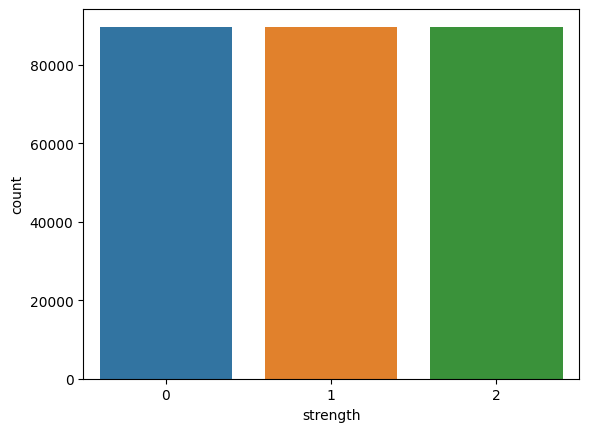

In [226]:
sns.countplot(x=data['strength'])

In [290]:

class pipe_model():
  def __init__(self,X_train,y_train,X_test,y_test):
    self.X_train = X_train
    self.y_train = y_train
    self.X_test = X_test  
    self.y_test = y_test

  def fit(self,pipe_filename):
    model = pipe_filename.fit(self.X_train,self.y_train)
    return model
  def model_score(self,model):
    score = model.score(self.X_test,self.y_test)
    return(score*100)

  def save(self,model,filename):
    pickle.dump(model, open( f'{filename}.sav', 'wb'))

  def load(self,filename):
    model = pickle.load(open(f'{filename}.sav', 'rb'))
    return model
 

class ANN:
    def __init__(self, input_size, output_size):
        self.model = Sequential()
        self.input_size = input_size
        self.output_size = output_size


    def add_layer(self, units, activation, input_size=None):
        if input_size == True:
            self.model.add(Flatten(input_shape=[self.input_size]))
            self.model.add(Dense(units, activation=activation))
        else:
            self.model.add(Dense(units,activation=activation))
    def Batch_normalization(self):
        self.model.add(BatchNormalization())
        
    def compile(self, optimizer, loss, metrics):
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def summary(self):
        return self.model.summary()

    def predict(self,model,list_to_predict):
        if range(len(list_to_predict)) == 1:
            predicted_values = model.predict(list_to_predict,verbose=0)
            return predicted_values
        else:
            predict = model.predict(list_to_predict,verbose=0)
            output = np.argmax((predict), axis = 1)
            return output
    def predict_strength(self,model,list_to_predict):
        if range(len(list_to_predict)) == 1:
            predicted_values = model.predict(list_to_predict,verbose=0)
            mapping_dict = {0:'weak',1:'acceptable',2:'strong'}
            result = [mapping_dict[x] for x in predicted_values]
        else:
            predict = model.predict(list_to_predict,verbose=0)
            output = np.argmax((predict), axis = 1)
            mapping_dict = {0:'weak',1:'acceptable',2:'strong'}
            result = [mapping_dict[x] for x in output]
        return result

   
    def fit(self, X_train, y_train, epochs, batch_size, verbose,validation_data=None):
        self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=validation_data, verbose=verbose)

    def evaluate(self, X_test, y_test):
        return self.model.evaluate(X_test, y_test,verbose=0)

    def save(self, file_):
        self.model.save(f'{file_}')
    
    def load(self, file_):
        model = keras.models.load_model(f'{file_}')
        return model

class optimizer:
  def __init__(self,X_train,y_train,X_test,y_test):
    self.X_train = X_train
    self.y_train = y_train
    self.X_test = X_test
    self.y_test = y_test


  def DCT_Classifier(self,min_depth,max_depth,depth_interval,trials):
    def objective(trial):
        DCT = DecisionTreeClassifier(
            #criterion=trial.suggest_categorical("criterion", ["gini", "entropy"]),
            max_depth=trial.suggest_int("max_depth",min_depth, max_depth, step=depth_interval),
            #max_features = trial.suggest_int("max_features",2,10),
            #min_samples_leaf=trial.suggest_int("min_samples_leaf", 2, 32, step=2),
            #min_samples_split=trial.suggest_int("min_samples_split", 2, 20, step=1),
        )
        DCT.fit(self.X_train, self.y_train)
        return DCT.score(self.X_train, self.y_train)
    
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=trials)
    best_trial = study.best_trial
    best_DCT = DecisionTreeClassifier(**best_trial.params)
    model = best_DCT.fit(self.X_train, self.y_train)
    train_score, test_score = model.score(self.X_train,self.y_train),model.score(self.X_test,self.y_test)

    return best_DCT,train_score,test_score

  def RFT_Classifier(self,min_depth,max_depth,depth_interval,min_n_estimators,high_n_estimators,trials):
    def objective(trial):
        rf = RandomForestClassifier(
            n_estimators=trial.suggest_int("n_estimators", min_n_estimators, high_n_estimators),
            max_depth=trial.suggest_int("max_depth", min_depth, max_depth, step=depth_interval),
            #max_features = trial.suggest_int("max_features",2,10)

            
            #min_samples_leaf=trial.suggest_int("min_samples_leaf", 2, 32, step=2),
            #min_samples_split=trial.suggest_int("min_samples_split", 2, 20, step=1),
            n_jobs=trial.suggest_int("n_jobs",-1,-1),
        )
        rf.fit(self.X_train, self.y_train)
        return rf.score(self.X_train, self.y_train)
    
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=trials)
    
    best_trial = study.best_trial
    best_RFT = RandomForestClassifier(**best_trial.params)
    model = best_RFT.fit(self.X_train, self.y_train)
    train_score, test_score = model.score(self.X_train,self.y_train),model.score(self.X_test,self.y_test)
    
    return best_RFT,train_score,test_score

def confusionMatrix(y_test,y_pred):
    cm = confusion_matrix(y_test,y_pred)
    pcm = ConfusionMatrixDisplay(confusion_matrix=cm)
    pcm.plot()
    plt.show()

def mapper(predicted_values):
    try:
        mapping_dict = {0:'weak',1:'acceptable',2:'strong'}
        result = [mapping_dict[x] for x in predicted_values]
    except TypeError:
        for i in predicted_values:
            mapping_dict = {0:'weak',1:'acceptable',2:'strong'}
            result = [mapping_dict[x] for x in i]
    return result


In [256]:
mapping_dict = {0:'weak',1:'acceptable',2:'strong'}
nlist = [1,2,0,1]
[mapping_dict[x] for x in nlist]


['acceptable', 'strong', 'weak', 'acceptable']

In [239]:
optimizer_ = optimizer(X_train,y_train,X_test,y_test)
DCT  = optimizer_.DCT_Classifier(1,200,1,100)
optimizer_ = optimizer(X_train,y_train,X_test,y_test)
RFT = optimizer_.RFT_Classifier(1,200,1,5,40,100)

[I 2023-01-11 17:21:52,963] A new study created in memory with name: no-name-7c19bee4-0d50-415d-a027-2b8f09af4d3b
[I 2023-01-11 17:22:02,319] Trial 0 finished with value: 0.9999070994593189 and parameters: {'max_depth': 128}. Best is trial 0 with value: 0.9999070994593189.
[I 2023-01-11 17:22:11,393] Trial 1 finished with value: 0.999837424053808 and parameters: {'max_depth': 78}. Best is trial 0 with value: 0.9999070994593189.
[I 2023-01-11 17:22:16,240] Trial 2 finished with value: 0.9224187584771744 and parameters: {'max_depth': 18}. Best is trial 0 with value: 0.9999070994593189.
[I 2023-01-11 17:22:25,085] Trial 3 finished with value: 0.9993032459448914 and parameters: {'max_depth': 64}. Best is trial 0 with value: 0.9999070994593189.
[I 2023-01-11 17:22:33,856] Trial 4 finished with value: 0.998940933836235 and parameters: {'max_depth': 60}. Best is trial 0 with value: 0.9999070994593189.
[I 2023-01-11 17:22:43,009] Trial 5 finished with value: 0.9999070994593189 and parameters: 

(DecisionTreeClassifier(max_depth=128), 0.9999070994593189, 0.9089946303487486)
(RandomForestClassifier(max_depth=77, n_estimators=40, n_jobs=-1), 0.9998885193511826, 0.9542929339848758)


In [240]:
print(DCT)
print(RFT)

(DecisionTreeClassifier(max_depth=128), 0.9999070994593189, 0.9089946303487486)
(RandomForestClassifier(max_depth=77, n_estimators=40, n_jobs=-1), 0.9998885193511826, 0.9542929339848758)


In [241]:
RFT = RandomForestClassifier(max_depth=77, n_estimators=40, n_jobs=-1)
DCT = DecisionTreeClassifier(max_depth=128)
XGB = XGBClassifier(objective='binary:logistic',random_state=42)
ABC = AdaBoostClassifier()
CBC = CatBoostClassifier(iterations = 600,verbose=0)

# Name of sickit learn classifiers 
clf_name = ['RandomForestClassifier','DecisionTreeClassifier','XGBClassifier','CatBoostClassifier','AdaBoostClassifier','VotingClassifier']
clf__ = []



In [242]:
# List for classifiers with parameters to be fed into pipeline

clf__.append(RFT)
clf__.append(DCT)
clf__.append(XGB)
clf__.append(CBC)
clf__.append(ABC)
clf__.append(VotingClassifier(estimators=[            
                                     ("XGBClassifier", XGB),
                                     ("RandomForestClassifier", RFT), 
                                     ("DecisionTree", DCT),
                                     ("AdaBoostClassifier", ABC),
                                     ]
                          ,voting = "hard"))
# initiating pipeline with a random classifier
pipeline = Pipeline([
    ('clf', RandomForestClassifier())])


ANN_model = ANN(143,3)
ANN_model.add_layer(416,'tanh',True)
ANN_model.add_layer(128,'tanh')
ANN_model.Batch_normalization()
ANN_model.add_layer(100,'tanh')
ANN_model.Batch_normalization()
ANN_model.add_layer(3,'sigmoid')


ANN_model.compile('Adam','sparse_categorical_crossentropy',['accuracy'])

In [244]:
# For loop in order to loop through classifiers and sending it to the pipe_line class

for i in range(len(clf_name)):
  pipeModel = pipe_model(X_train,y_train,X_test,y_test)
  pipeline.set_params(clf = clf__[i])
  model = pipeModel.fit(clf__[i])
  print(f'\n{clf_name[i]}\n')
  accuracy  = pipeModel.model_score(model)
  print(accuracy)
  pipeModel.save(model,clf_name[i])
  

# Adding layers and batch normalization to the Artifical Neural Network sequntial model

ANN_model.fit(X_train, y_train, 50, 1000, verbose=0 ,validation_data=(X_test, y_test))
print(f'\nAritifical Neural Network\n')
accuracy  = ANN_model.evaluate(X_test,y_test)
print(accuracy[1]*100)
ANN_model.save("ANN_model")



RandomForestClassifier

95.36054699838353

DecisionTreeClassifier

90.94777131602906

XGBClassifier

98.38538860296167

CatBoostClassifier

97.61245610449453

AdaBoostClassifier

83.02707121755448

VotingClassifier

97.04947882796678

Aritifical Neural Network

98.65294098854065
INFO:tensorflow:Assets written to: ANN_model/assets


INFO:tensorflow:Assets written to: ANN_model/assets



 RandomForestClassifier 



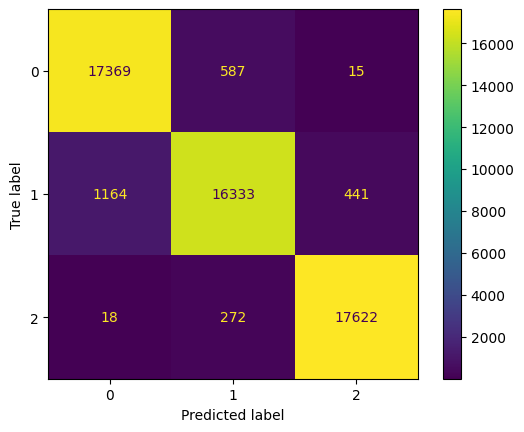


 DecisionTreeClassifier 



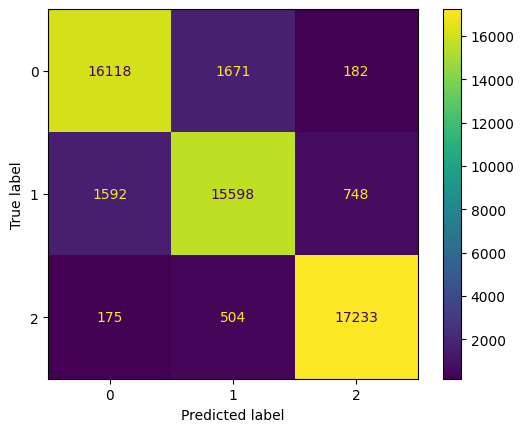


 XGBClassifier 



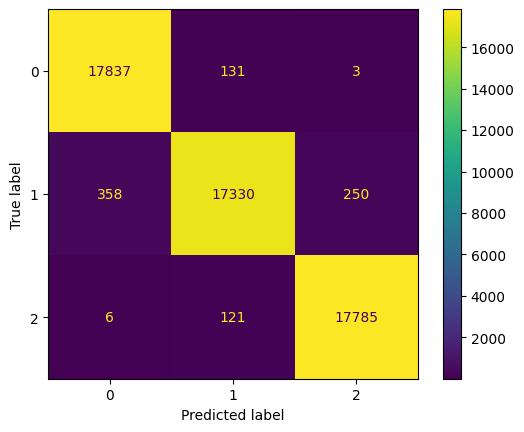


 CatBoostClassifier 



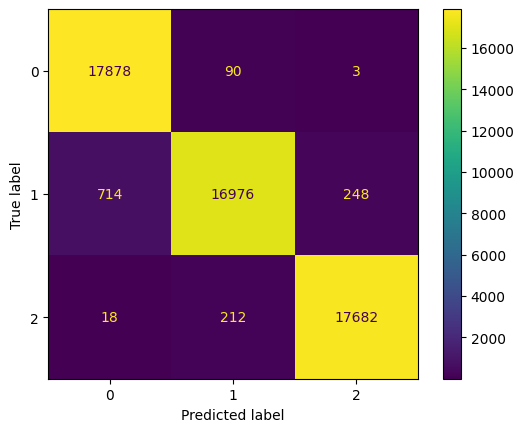


 AdaBoostClassifier 



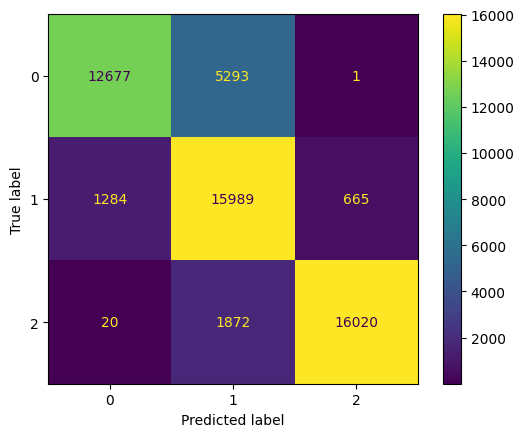


 VotingClassifier 



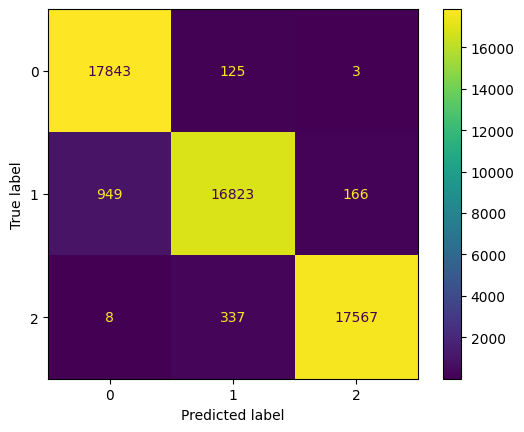


Artificial Neural Network



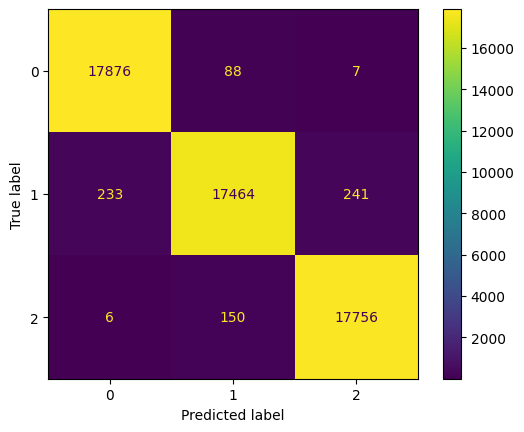

In [293]:
# Illustrating Confusion matrix with a visual graph 

# Confusion Matrix for pipeline classifiers
for i in range(len(clf_name)):
  pipeModel = pipe_model(X_train,y_train,X_test,y_test)
  model = pipeModel.load(clf_name[i])
  print("\n",clf_name[i],"\n")
  y_pred = model.predict(X_test)
  confusionMatrix(y_test,y_pred)

# Confusion Matrix for ANN
ANNmodel = ANN(143,3)
model = ANNmodel.load("ANN_model")
print("\nArtificial Neural Network\n")
y_pred = ANNmodel.predict(model,X_test)
confusionMatrix(y_test,y_pred)

In [292]:

# Creating a list and vectorizing it to be predicted
''' Password to be checked '''
list_of_pass = ['BroUing']
vectorized_pass = vectorizer.transform(list_of_pass)
vectorized_pass = vectorized_pass.toarray()


for i in  range(len(clf_name)):
  pipeModel = pipe_model(X_train,y_train,X_test,y_test)
  model = pipeModel.load(clf_name[i])
  predict = mapper(model.predict(vectorized_pass))
  print("\n",clf_name[i],"\n")
  print(predict)

ANNmodel = ANN(143,3)
model = ANNmodel.load("ANN_model")
print("\nArtificial Neural Network\n")
predict  = ANNmodel.predict_strength(model,vectorized_pass)

print(predict)






 RandomForestClassifier 

['weak']

 DecisionTreeClassifier 

['weak']

 XGBClassifier 

['weak']

 CatBoostClassifier 

['weak']

 AdaBoostClassifier 

['weak']

 VotingClassifier 

['weak']

Artificial Neural Network

['weak']
